# 7장 케라스 완전 정복

## 7.1 다양한 워크플로
- 케라스 API 설계는 복잡성의 단계적 공개(progressive disclosure) 원칙을 따름


## 7.2 케라스 모델을 만드는 여러 방법
- Sequential 모델
- 함수형 API
- Model 서브클래싱

### 7.2.1 Sequential 모델
---

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [4]:
# build로 모델을 한 번 호출해야 모델의 가중치를 만들 수 있다.
model.build(input_shape=(None, 3))
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.25431392,  0.20526904, -0.05850653, -0.14174044, -0.06481999,
          0.12206724,  0.13848636, -0.16149768,  0.26909208,  0.04543054,
         -0.08388923,  0.28449118, -0.27970552,  0.0892607 ,  0.11757743,
          0.2739141 , -0.1646362 , -0.15263398,  0.09424075, -0.28604874,
         -0.00692514, -0.13341498,  0.23670655,  0.25227922, -0.1878874 ,
         -0.12073584, -0.21116449, -0.18090326,  0.26548028,  0.14192495,
          0.07007331,  0.02145487,  0.1642487 ,  0.13790444,  0.27503598,
          0.07080591,  0.23179805, -0.09857404, -0.06436537,  0.28349382,
         -0.12361206, -0.18314299,  0.25516433, -0.14760555, -0.2725556 ,
          0.09036046,  0.26657695, -0.03748173, -0.05247854, -0.28152362,
         -0.01914993, -0.17830592, -0.1047269 , -0.02181083,  0.15849167,
          0.28455305, -0.24769115,  0.12493506, -0.12216264, -0.25890726,
         -0.13738033, -0.03646183,  0.00132

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [7]:
# 모델과 층에 모두 이름 지정이 가능하다

model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 모델의 build 없이 summary를 확인하기 위해선 입력 크기를 미리 지정해주면 된다.

model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 7.2.2 함수형 API
---

In [14]:
# 다중 입력, 다중 출력, 비선형적인 구조의 모델을 만드는 데 사용

# 심볼릭 텐서 : 실제 데이터를 가지고 있지 않지만 사용할 데이터 텐서의 사양이 인코딩 되어 있음
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


40/40 [==============================] - 1s 8ms/step - loss: 32.1072 - priority_loss: 0.3330 - department_loss: 31.7742 - priority_mean_absolute_error: 0.4960 - department_accuracy: 0.1180


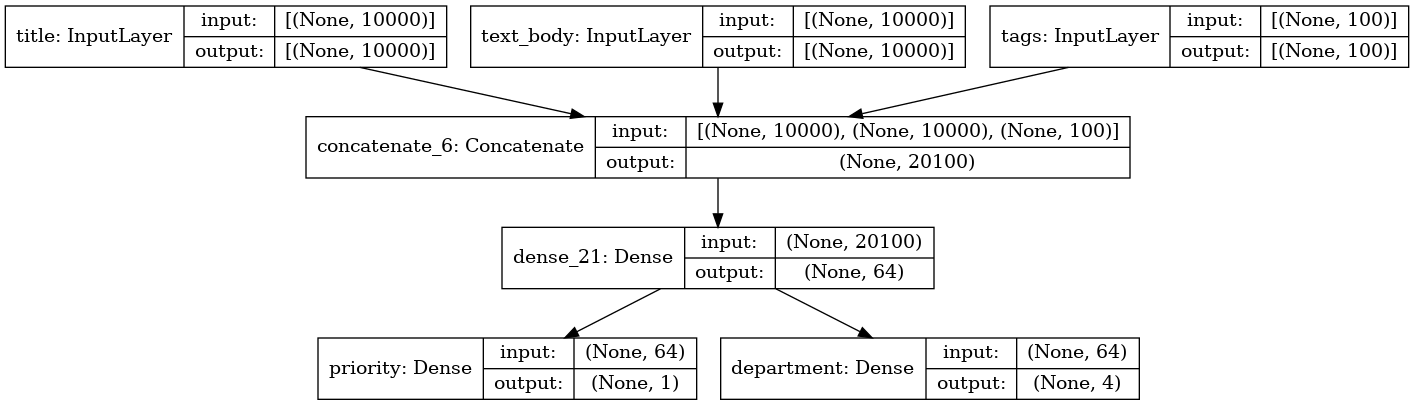

In [29]:
# 다중 입력, 다중 출력 모델
import numpy as np

vocabulary_size = 10000
num_tags = 100
num_departments = 4

# model
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags],
                   outputs=[priority, department])

# data
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

# compile fit eval
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})
keras.utils.plot_model(model, show_shapes=True)

### 7.2.3 Model 서브클래싱
---

In [30]:
# 3 Subclassing

class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 1s 11ms/step - loss: 7.7952 - output_1_loss: 0.3411 - output_2_loss: 7.4542 - output_1_mean_absolute_error: 0.5040 - output_2_accuracy: 0.2602


### 7.2.4 여러 방식을 혼합하여 사용하기
---

In [34]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

11501568/11490434 [==============================] - 0s 0us/step


In [35]:
import tensorflow as tf
from tensorflow import keras

# Quest: 사용자 정의 훈련 스텝을 사용하는 모델
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

from tensorflow.keras import layers

inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.9115
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.9520
Epoch 3/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1392 - sparse_categorical_accuracy: 0.9621
